# WER on single recording end to end

#### Common packages

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from graphviz import Digraph
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

## Amharic

In [4]:
from Cfg import Cfg
C = Cfg('NIST', 8000, 'amharic') 

## Split Corpus into Recordings $\langle A_i,T_i \rangle$

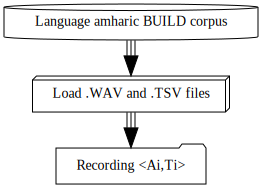

In [5]:
import split_corpus_into_recordings
split_corpus_into_recordings.diagram(C)

In [6]:
from RecordingCorpus import RecordingCorpus
from multiprocessing import Pool
from contextlib import closing
if __name__ == '__main__':
    with closing(Pool(16)) as pool:
        recordings = RecordingCorpus(C, pool)

100%|██████████| 122/122 [00:02<00:00, 44.71it/s]


In [7]:
id_recording={x.key:x for x in recordings.artifacts}

## Split Recordings $\langle A_i,T_i \rangle$ into Splits $\langle A_{i,j}, T_{i,j} \rangle$ 

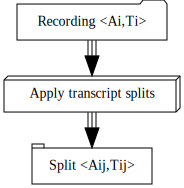

In [8]:
import split_recordings_into_splits
split_recordings_into_splits.diagram(C)

In [9]:
from SplitCorpus import SplitCorpus
splits=SplitCorpus.from_recordings(C, recordings)

In [10]:
id_splits={x.key:x for x in splits.artifacts}

## Subsplit $A_{i,j}$ on silence and apportion text to trimmed chunks by word sizes in $T_{i,j} = \langle w_{i,j,k} \rangle$ where $w_{i,j,k}=\langle g_{i,j,k,l} \rangle$

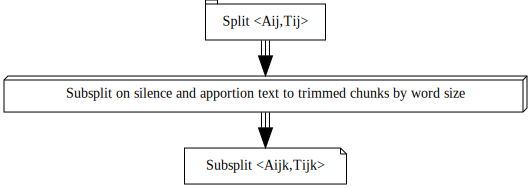

In [11]:
import subsplit_Aij_on_silence_and_apportion_text_by_size
subsplit_Aij_on_silence_and_apportion_text_by_size.diagram

In [ ]:
import pickle
from SubSplitCorpus import SubSplitCorpus
if __name__=="__main__":
    if True:
        with closing(Pool(16)) as pool:
            subsplits=SubSplitCorpus(pool, splits, min_words=2)
        with open('bfgpu.pkl', 'wb') as f:
            pickle.dump(subsplits,f)
    else:
        with open('bfgpu.pkl', 'rb') as f:
            subsplits=pickle.load(f)

 82%|████████▏ | 8534/10359 [07:30<04:04,  7.45it/s]  

In [ ]:
id_subsplits={x.key:x for x in subsplits.artifacts}

In [ ]:
len([x for x in subsplits.artifacts if not x.good_split()])

# Infer ASR NN on subsplits $A_{i,j,k} \to P_{i,j,k} \approx T_{i,j,k}$

In [ ]:
import train_ASR_NN_on_subsplits
train_ASR_NN_on_subsplits.diagram

In [ ]:
import os
os.environ['IN_JUPYTER']='True'

In [ ]:
from ASR_NN import ASR_NN

In [ ]:
model_ASR = ASR_NN(C);

In [ ]:
model_ASR.load_model();

In [ ]:
model_ASR.load_training_set(subsplits, batch_size=24)

In [ ]:
ASR_output = model_ASR.infer()

In [ ]:
ASR_scores = model_ASR.score(ASR_output)

Clean up GPU memory for next phase

In [ ]:
import torch
del model_ASR
torch.cuda.empty_cache() 

## Concatenate $P_{i,j,k}$ giving $P_{i,j} = P_{i,j,1}\|\cdots\|P_{i,j,-1}$

In [ ]:
import concatenate_Pikj_giving_Pij
concatenate_Pikj_giving_Pij.diagram

In [ ]:
ASR_scores.gold.loc[0]

In [ ]:
artifact_map={artifact.target.value:artifact for artifact in subsplits.artifacts}

In [ ]:
gha=list(sorted(set([(artifact_map[gold].root, artifact_map[gold].key, gold,hyp) for gold,hyp in ASR_scores[['gold', 'hyp']].values])))

In [ ]:
id_splits={id(x):x for x in splits.artifacts}

In [ ]:
id_subsplits={id(x):x for x in subsplits.artifacts}

In [ ]:
id_recordings={id(x):x for x in recordings.artifacts}

In [ ]:
[140244667653424 in y for y in [id_subsplits,id_splits,id_recordings]]

In [ ]:
gha[0:50]

In [ ]:
Pijk=ASR_output.pred
Pij=ASR_NN_trainer.concatenate(Pijk)

In [ ]:
ASR_scores

In [ ]:
len(subsplits.artifacts), len(ASR_output)

In [ ]:
ASR_scores.gold.loc[0:5]

In [ ]:
[x.target.value for x in subsplits.artifacts[0:5]]

## Infer text-to-text corrector on both $P_{i,j,k} \to Q_{i,j,k} \approx T_{i,j,k}$ and $P_{i,j} \to Q_{i,j} \approx T_{i,j}$ and score

In [ ]:
import train_text_to_text_corrector_on_Pij_and_Pijk_and_score
train_text_to_text_corrector_on_Pij_and_Pijk_and_score.diagram

In [ ]:
torch.cuda.empty_cache()

## Subsplit $A_{i,j}$ on silence alone retaining timecode $(s_{i,j,k},e_{i,j,k})$ giving $A_{i,j} = \langle (\alpha_{i,j,k}, (s_{i,j,k},e_{i,j,k})) \rangle$ so that $\alpha_{i,j,k} = A_{i,j}[s_{i,j,k}:e_{i,j,k}]$

In [ ]:
import subsplit_Aij_on_silence_retaining_timecode
subsplit_Aij_on_silence_retaining_timecode.diagram

## Infer $(\alpha_{i,j,k}, (s_{i,j,k},e_{i,j,k})) \xrightarrow{ASR} p_{i,j,k} $

In [ ]:
import infer_aijk_giving_pijk
infer_aijk_giving_pijk.diagram

In [ ]:
torch.cuda.empty_cache() 

## Concatenate $p_{i,j,k} \to p_{i,j}$

In [ ]:
import concatenate_pikj_giving_pij
concatenate_pikj_giving_pij.diagram

## Infer $p_{i,j} \xrightarrow{TT} (q_{i,j},(s_{i,j,0},e_{i,j,-1}))$ 

In [ ]:
import infer_pij_giving_qij
infer_pij_giving_qij.diagram

In [ ]:
torch.cuda.empty_cache() 

## Concatenate $\langle \langle (q_{i,j,k},(s_{i,j,k},e_{i,j,k})) \rangle \rangle $ giving transcript $Q_i = \langle (q_{i,j}, (s_{i,j,0},e_{i,j,-1})) \rangle$

In [ ]:
import concatenate_qijk_giving_Qi
concatenate_qijk_giving_Qi.diagram

## Save transcript $Q_i$ in .CTM format

In [ ]:
import save_transcript_Qi_in_CTM_format
save_transcript_Qi_in_CTM_format.diagram

## Score $\langle T_i,Q_i\rangle$ using `sclite` for each recording individually

In [ ]:
import score_TiQi_using_sclite_per_recording
score_TiQi_using_sclite_per_recording.diagram

## Score $\langle T_i,Q_i\rangle$ using `sclite` collectively

In [ ]:
import score_TiQi_using_sclite_on_all_recordings_together
score_TiQi_using_sclite_on_all_recordings_together.diagram